In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

walk = pd.read_csv('walk_1.csv')

    time  Hips.x  Hips.y  Hips.z  RightUpLeg.x  RightUpLeg.y  RightUpLeg.z  \
0  0.000       0       0       0       8.56602      -1.92634       3.31710   
1  0.008       0       0       0       8.56601      -1.92634       3.31710   
2  0.016       0       0       0       8.55181      -2.03670       3.28768   
3  0.024       0       0       0       8.55046      -2.06077       3.27620   
4  0.032       0       0       0       8.54885      -2.08047       3.26793   

   RightLeg.x  RightLeg.y  RightLeg.z  ...  RightFoot.z  LeftUpLeg.x  \
0     1.32760   -42.78508    -2.27446  ...     -3.13600     -8.55652   
1     1.32760   -42.78508    -2.27446  ...     -3.12737     -8.55652   
2     1.32299   -42.87439    -2.46767  ...     -3.31271     -8.55268   
3     1.31772   -42.89337    -2.51027  ...     -3.35641     -8.55284   
4     1.32091   -42.92101    -2.46830  ...     -3.32241     -8.55262   

   LeftUpLeg.y  LeftUpLeg.z  LeftLeg.x  LeftLeg.y  LeftLeg.z  LeftFoot.x  \
0     -1.23578     -3.

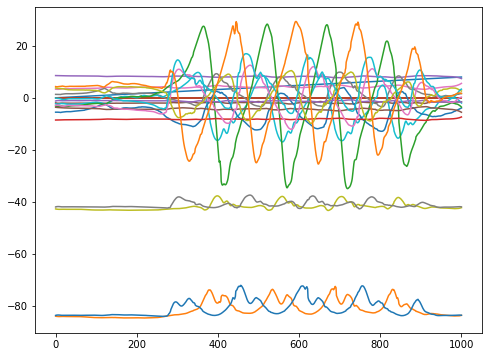

In [2]:
print(walk.head())
print(walk.columns)
plt.plot(walk)

walk.head()는 DataFrame갱체의 작은 샘플을 보기위해 사용함. 입력한 숫자만큼 raw를 출력하지만 기본적으로 5개의 행을 출력하도록 되어있음<br>
출력 결과를 보면 22개의열(columns)을 갖고 0.008초 간격으로 기록된 데이터임을 알 수 있음<br>
따라서 1초당 125개의 데이터가 있음

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from(histroy_size, )to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size , 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

histroy_size는 과거 데이터의 크기를 의미함<br>
target_size는 모델이 얼마 동안의 미래를 예측할지를 의미함.

In [4]:
TRAIN_SPLIT = 700
tf.random.set_seed(13)

700개의 raw 데이터를 훈련에 사용하고 이후의 데이터를 검증에 사용함.<br>
700개의 데이터는 대략 5.6초의 데이터임
재현성 보장을 위해 시드 설정

### 단변량 시계열 데이터 예측하기
<br>오른발 데이터 추출

In [5]:
uni_data = walk['RightFoot.x']
uni_data.index = walk['time']
print(uni_data.head())

time
0.000   -5.53755
0.008   -5.52978
0.016   -5.52768
0.024   -5.53272
0.032   -5.53215
Name: RightFoot.x, dtype: float64


시간 - 오른발.x값 두개의 Column을 갖는 데이터 생성

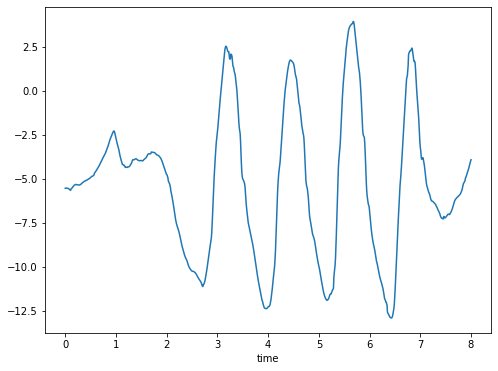

In [6]:
uni_data.plot(subplots=True)
plt.show()


### 표준화(Standardization)

<br> uni_data에 대해서 평균을 빼고 표준편차로 나누어줌으로써 표준화 진행

[-0.04950928 -0.04755929 -0.04703226 ...  0.32007448  0.34068875
  0.35710438]


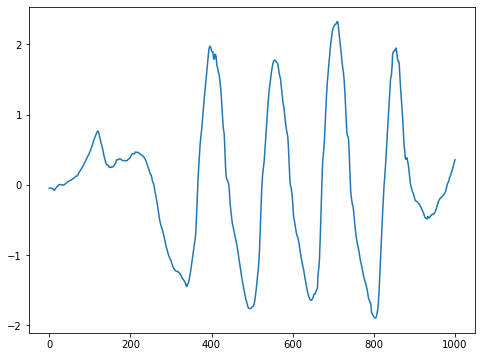

In [7]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization

print(uni_data)
plt.plot(uni_data)


### 첫번째 예측
<br> 단변량 모델을 위한 데이터 생성
<br> 우선적으로 20개의 값을 입력하여 다음 시간 스텝의 온도를 예측하도록함

In [8]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                     univariate_past_history,
                                     univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-0.04950928]
 [-0.04755929]
 [-0.04703226]
 [-0.04829712]
 [-0.04815407]
 [-0.04823689]
 [-0.04897724]
 [-0.05141913]
 [-0.05423496]
 [-0.05835329]
 [-0.06321198]
 [-0.06804055]
 [-0.07498224]
 [-0.07992124]
 [-0.05989171]
 [-0.0564033 ]
 [-0.05051064]
 [-0.0433757 ]
 [-0.03612783]
 [-0.03094791]]

 Target temperature to predict
-0.021913161526076017


위 출력 결과는 univariate_data()함수가 만든 20개의 과거 데이터와 1개의 목표 예측 값을 나타냄

In [9]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

create_time_steps()함수는 데이터의 길이를 이용하여 시간 스텝값들을 만듭니다.

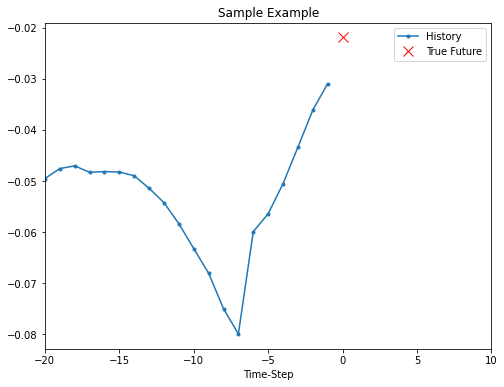

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

파란 마커가 20개의 과거 데이터, 빨간 마커가 예측해야할 미래(실제)의 값을 나타냄

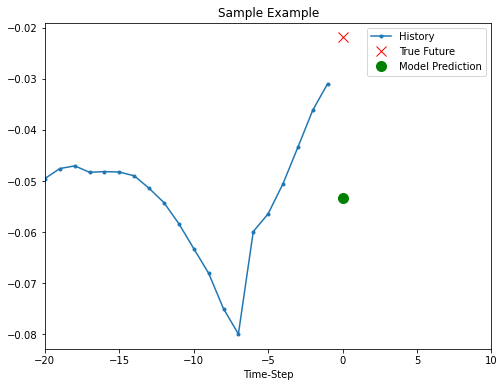

In [11]:
def baseline(history):
    return np.mean(history)


show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()

baseline 함수는 과거의 20개의 데이터를 받아서 평균을 반환하는 함수임.<br>
이 평균값을 첫번째 예측으로 사용해서 그래프로 나타내봄<br>
녹색 마커는 과거의 온도 데이터 평균값을 이용해서 예측한 지점을 나타냄.

## 순환 신경망 사용하기

### shuffle, batch, cache

In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 1000

In [13]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

cache()는 데이터셋을 캐시, 즉 메모리 또는 파일에 보관합니다. 따라서 두번째 이터레이션부터는 캐시된 데이터를 사용합니다.<br>

shuffle()는 데이터셋을 임의로 섞어줍니다. BUFFER_SIZE개로 이루어진 버퍼로부터 임의로 샘플을 뽑고, 뽑은 샘플은 다른 샘플로 대체합니다. 완벽한 셔플을 위해서 전체 데이터셋의 크기에 비해 크거나 같은 버퍼 크기가 요구됩니다.<br>

batch()는 데이터셋의 항목들을 하나의 배치로 묶어줍니다.

## LSTM(Long Short Term Memory)

In [14]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [15]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 19ms/step - loss: 0.5618 - val_loss: 0.1826
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 0.1145 - val_loss: 0.0845
Epoch 3/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0460 - val_loss: 0.0558
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0290 - val_loss: 0.0438
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0233 - val_loss: 0.0354
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0192 - val_loss: 0.0321
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0170 - val_loss: 0.0284
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0154 - val_loss: 0.0257
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0142 - val_loss: 0.0236
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0133 - val_lo

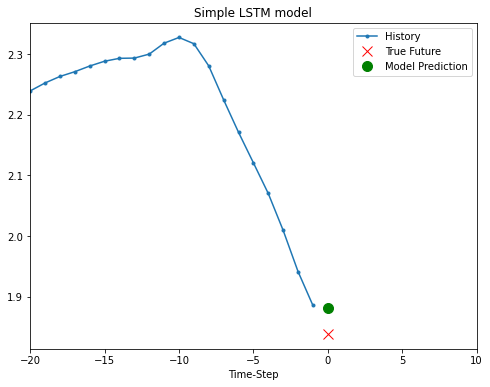

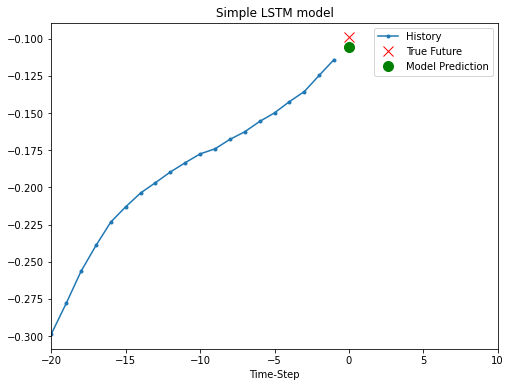

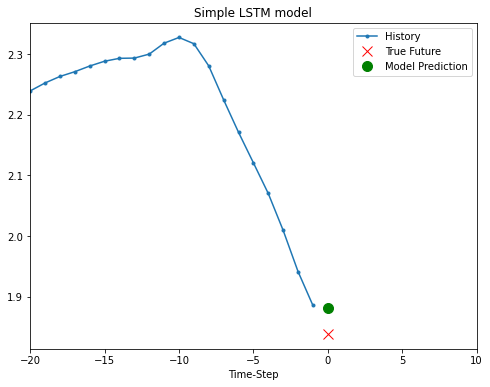

In [16]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [17]:
RF = ['RightFoot.x','RightFoot.y','RightFoot.z']
RF = walk[RF]
RF.index = walk['time']
print(RF.head())

       RightFoot.x  RightFoot.y  RightFoot.z
time                                        
0.000     -5.53755    -84.07944     -3.13600
0.008     -5.52978    -84.08092     -3.12737
0.016     -5.52768    -84.17150     -3.31271
0.024     -5.53272    -84.19050     -3.35641
0.032     -5.53215    -84.21754     -3.32241


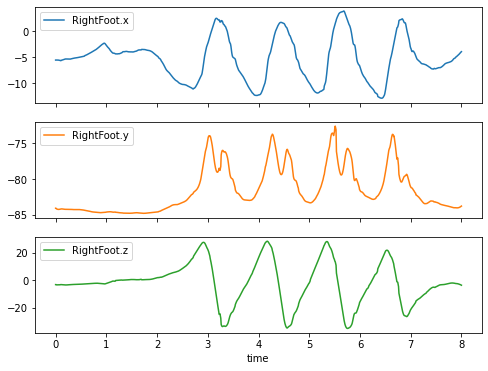

In [18]:
RF.plot(subplots=True)
plt.show()

In [19]:
dataset = RF.values
RF_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
RF_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-RF_mean)/RF_std
print(dataset)

[[-0.04950928 -0.71535665 -0.26756809]
 [-0.04755929 -0.71580022 -0.26698471]
 [-0.04703226 -0.74294783 -0.2795134 ]
 ...
 [ 0.32007448 -0.65229797 -0.27535745]
 [ 0.34068875 -0.63973419 -0.28591835]
 [ 0.35710438 -0.62571083 -0.29736072]]


In [20]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [21]:
past_history = 600
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,
                                               future_target, STEP, single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape)

Single window of past history : (100, 3)
(100, 100, 3)


In [22]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and Validation Loss')

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 0.4001

ValueError: in user code:

    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/master/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)
